In [15]:
import algo
import datamodel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

In [16]:
fname = "Data/prices_round_1_day_-1.csv"
output = pd.read_csv(fname, index_col=False, sep=";")
times = output['timestamp'].unique()
dfs = {elem : {} for elem in times}
mtm_value = pd.DataFrame(index = output['timestamp'].unique())
for key in dfs.keys():
    df_temp = output[:][output['timestamp'] == key]
    products = df_temp['product'].unique()
    int_dfs = {elem : pd.DataFrame() for elem in products}
    for int_key in int_dfs:
        dfs[key][int_key] = df_temp[:][df_temp["product"] == int_key]




In [17]:
mtm_value.index.name = 'Time'
mtm_value['Cash'] = 0
mtm_value['Value'] = 0
position = {}
trader = algo.Trader()
for time in times:
    print(time)
    listings = {}
    order_depths = {}
    own_trades = {}
    market_trades = {}
    observations = {}
    for product in dfs[time].keys():
        # print(dfs[time][product])
        depth = datamodel.OrderDepth()
        try:
            depth.buy_orders = {int(dfs[time][product]["bid_price_1"]):int(dfs[time][product]["bid_volume_1"]), int(dfs[time][product]["bid_price_2"]):int(dfs[time][product]["bid_volume_2"])}
        except:
            depth.buy_orders = {int(dfs[time][product]["bid_price_1"]):int(dfs[time][product]["bid_volume_1"])}
        try:
            depth.sell_orders = {int(dfs[time][product]["ask_price_1"]):-int(dfs[time][product]["ask_volume_1"]), int(dfs[time][product]["ask_price_2"]):-int(dfs[time][product]["ask_volume_2"])}
        except:
            depth.sell_orders = {int(dfs[time][product]["ask_price_1"]):-int(dfs[time][product]["ask_volume_1"])}
        order_depths[product] = depth
    state = datamodel.TradingState(
                 timestamp= time,
                 listings= listings,
                 order_depths= order_depths,
                 own_trades= own_trades,
                 market_trades= market_trades,
                 position= position,
                 observations= observations)
    trades = trader.run(state = state)
    cash = mtm_value.loc[time]['Cash']
    for trade in trades:
        if trade not in position:
            try:
                position[trade] =  trades[trade][0].quantity
                cash += -trades[trade][0].quantity*trades[trade][0].price
            except:
                continue
        else:
            try:
                position[trade] += trades[trade][0].quantity
                cash += -trades[trade][0].quantity*trades[trade][0].price
            except:
                continue
    value = cash
    # mtm valuation using best price to have no net assets
    for asset, pos in position.items():
        if pos<0:
            value = value + pos*min(order_depths[asset].sell_orders.keys())
        if pos>0:
            value = value + pos*max(order_depths[asset].sell_orders.keys())

    mtm_value.loc[time]['Value'] = value
    mtm_value.loc[time]['Cash'] = cash
    try:
        mtm_value.loc[time+100]['Cash'] = cash
        mtm_value.loc[time+100]['Value'] = cash
    except:
        continue
    #print(trades)

        # print(time, product, dfs[time][product])

0
SELL PEARLS 1x 10002
delta 4896.61 4897.16
delta 4896.61 4897.16
100
delta 4897.17 4898.3
delta 4897.17 4898.3
200
delta 4897.74 4899.44
delta 4897.74 4899.44
300
delta 4898.34 4900.56
delta 4898.34 4900.56
400
delta 4898.9 4901.7
delta 4898.9 4901.7
500
delta 4899.44 4902.82
delta 4899.44 4902.82
600
delta 4900.0 4903.96
delta 4900.0 4903.96
700
delta 4900.55 4905.1
delta 4900.55 4905.1
800
delta 4901.08 4906.2
delta 4901.08 4906.2
900
delta 4901.61 4907.36
delta 4901.61 4907.36
1000
delta 4902.15 4908.46
delta 4902.15 4908.46
1100
delta 4902.68 4909.54
delta 4902.68 4909.54
1200
BUY PEARLS 1x 9998
delta 4903.24 4910.66
delta 4903.24 4910.66
1300
SELL PEARLS 1x 10002
delta 4903.8 4911.8
delta 4903.8 4911.8
1400
delta 4904.35 4912.9
delta 4904.35 4912.9
1500
delta 4904.89 4914.02
delta 4904.89 4914.02
1600
delta 4905.45 4915.16
delta 4905.45 4915.16
1700
delta 4905.98 4916.24
delta 4905.98 4916.24
1800
delta 4906.54 4917.36
delta 4906.54 4917.36
SELL PEARLS 1x 10002
1900
delta 4907.1

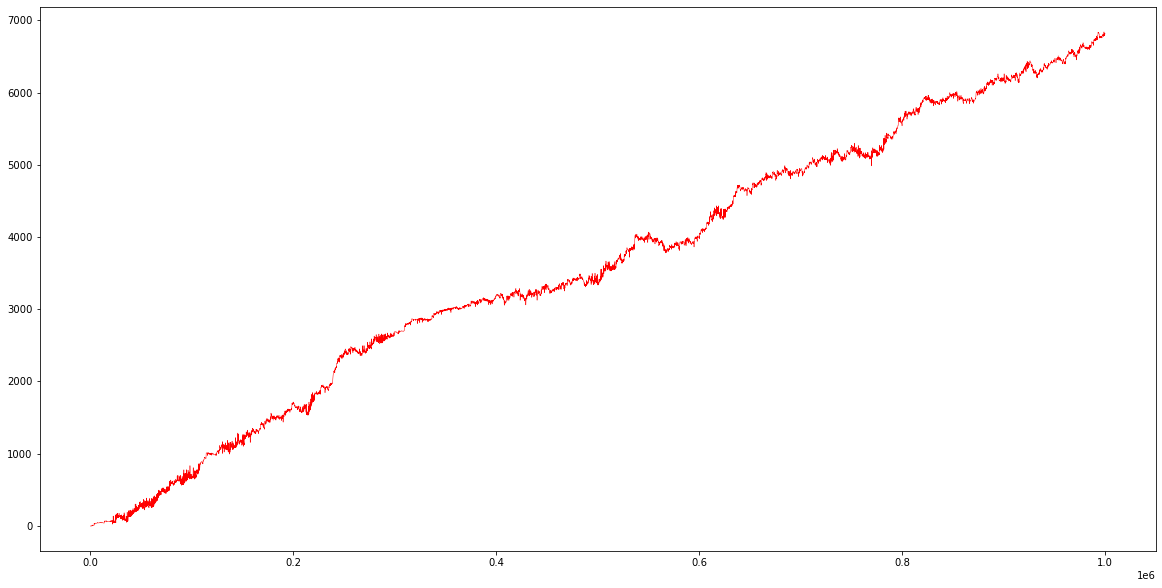

In [18]:
plt.plot(mtm_value['Value'] , linewidth = 0.5, color = "red")
plt.show()